# **2023 NFL Big Data Bowl EDA**
### Sol Ben-Ishay

## **Extract+Clean the Data**

In [1]:
# Import libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import nfl_data_py as nfl

In [2]:
# Read in the internal BDB competition data
games_df = pd.read_csv("../Data/games.csv")
plays_df = pd.read_csv("../Data/plays.csv")
players_df = pd.read_csv("../Data/players.csv")
scouting_df = pd.read_csv("../Data/pffScoutingData.csv")
tracking_df_list = ["../Data/tracking/week1.csv", "../Data/tracking/week2.csv", "../Data/tracking/week3.csv", "../Data/tracking/week4.csv",
"../Data/tracking/week5.csv", "../Data/tracking/week6.csv", "../Data/tracking/week7.csv", "../Data/tracking/week8.csv"]
tracking_df = pd.concat(map(pd.read_csv, tracking_df_list))

In [3]:
# Read in external nflverse data
# Weekly QBR data
# coi = ['game_id', 'game_week', 'team_abb', 'opp_abb', 'player_id', 'name_display', 'rank', 'qbr_total', 'pts_added',
#        'qb_plays', 'epa_total', 'pass', 'run', 'exp_sack', 'penalty', 'qbr_raw', 'sack', 'name_first', 'name_last',
#        'headshot_href', 'team', 'week_num', 'qualified']
# qbr_df = nfl.import_qbr(years=[2021],frequency='weekly').query("game_week in [1,2,3,4,5,6,7,8]")[coi]

# # Additional play-by-play data
# coi = ['game_id','old_game_id','play_id','week','ep','epa']
# extra_coi = ['total_home_pass_epa','total_away_pass_epa',
# 'total_home_raw_air_epa','total_away_raw_air_epa','total_home_pass_wpa',
# 'total_away_pass_wpa','qb_epa','air_wpa']
# nflverse_pbp_df = nfl.import_pbp_data(years=[2021],columns=coi,include_participation=False,cache=True).query("week in [1,2,3,4,5,6,7,8]")

# nflverse_pbp_df = nflverse_pbp_df.drop(columns=['game_id','week','season'])
# nflverse_pbp_df['old_game_id'] = nflverse_pbp_df['old_game_id'].astype("int")

# nflverse_pbp_df.head()

In [4]:
# Get the play-level data
coi = ['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'playId',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'foulName1', 'foulNFLId1',
       'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType']
play_level_df = games_df.merge(plays_df, on='gameId', how='left')[coi]

# Replace n/a dropBackType and yardlineSide
play_level_df = play_level_df.fillna(value={'yardlineSide': 'MIDDLE'})

play_level_df.head(5)

,gameId,season,week,homeTeamAbbr,visitorTeamAbbr,playId,playDescription,quarter,down,yardsToGo,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,2021,1,TB,DAL,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,2021,1,TB,DAL,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,2021,1,TB,DAL,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,...,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,2021,1,TB,DAL,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,...,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [5]:
# Check for NA data
ok_na_cols = ["penaltyYards", "foulName1", "foulNFLId1", "foulName2", "foulNFLId2",
            "foulName3", "foulNFLId3", "absoluteYardlineNumber", "offenseFormation",
            "personnelO", "defendersInBox", "personnelD", "dropBackType"]
if sum(play_level_df.loc[:,~play_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(play_level_df.isna().sum().loc[lambda x: x > 0])

In [6]:
# Get the player-level data
coi = ['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry',
       'pff_sack', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed', 'pff_nflIdBlockedPlayer',
       'pff_blockType', 'pff_backFieldBlock']
player_level_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(scouting_df, on=['gameId','playId'], how='left')
                .merge(players_df, on='nflId', how='left'))[coi]
                
player_level_df.head(5)

,gameId,playId,nflId,displayName,officialPosition,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Tom Brady,QB,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Rob Gronkowski,TE,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Antonio Brown,WR,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Giovani Bernard,RB,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Ryan Jensen,C,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [7]:
# Check for NA data
ok_na_cols = ["pff_hit", "pff_hurry", "pff_sack", "pff_beatenByDefender",
            "pff_hitAllowed", "pff_hurryAllowed", "pff_sackAllowed",
            "pff_nflIdBlockedPlayer", "pff_blockType", "pff_backFieldBlock"]
if sum(player_level_df.loc[:,~player_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(player_level_df.isna().sum().loc[lambda x: x > 0])

In [8]:
# Get the frame-level data
coi = ['gameId', 'playId', 'frameId', 'event', 'time', 'nflId', 'displayName', 'team', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
frame_level_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(tracking_df, on=['gameId','playId'], how='left')
                .merge(players_df, on='nflId', how='left'))[coi]

# Convert dt_time column to time
frame_level_df['time'] = pd.to_datetime(frame_level_df['time'])

# Replace n/a values for ball rows   
frame_level_df = frame_level_df.fillna(value={"nflId":0,"displayName":"ball"})

frame_level_df.head(5)

,gameId,playId,frameId,event,time,nflId,displayName,team,playDirection,x,y,s,a,dis,o,dir
0,2021090900,97,1,None,2021-09-10 00:26:31.100,25511.0,Tom Brady,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99
1,2021090900,97,2,None,2021-09-10 00:26:31.200,25511.0,Tom Brady,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87
2,2021090900,97,3,None,2021-09-10 00:26:31.300,25511.0,Tom Brady,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55
3,2021090900,97,4,None,2021-09-10 00:26:31.400,25511.0,Tom Brady,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85
4,2021090900,97,5,None,2021-09-10 00:26:31.500,25511.0,Tom Brady,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55


In [9]:
# Check for NA data
ok_na_cols = ['o','dir']
if sum(frame_level_df.loc[:,~frame_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(frame_level_df.isna().sum().loc[lambda x: x > 0])

## **Feature Engineering**

### **Snap to Action Time**

*Get the time from snap to an action event for each play for further analyses*

An action event is defined as the earliest of the following:  
  - A throw  
  - A non-throw, but play-ending event (QB sack, strip sack)
  - Any play where the QB doesn't scramble  
  - NOT YET: 3.5 seconds post-snap

A hard time cap is useful for reducing noise introduced by “broken” plays. Plays without a targeted receiver are not used for training, but are included for predictions so that players can be quantified on all pass plays.

In [10]:
# 1. Get the time of all the key events for each play (all individual snap/action events)
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
conds = f"(event in {potential_snap_events}) or (event in {potential_action_events})"
coi = ['gameId', 'playId', 'event', 'frameId', 'time']
play_event_times_df = frame_level_df.query(conds)[coi].drop_duplicates()

# 2. Get the time of the snap and action event for each play
# Note: Not distinguishing snap/action times based on if they're from auto/manual events
# Utilizing the times of the earliest snap and earliest action event to calculate the snap to action time.
play_event_times_df.loc[play_event_times_df['event'].isin(potential_snap_events),'event'] = "ballsnap"
play_event_times_df.loc[play_event_times_df['event'].isin(potential_action_events),'event'] = "action"
play_event_times_df = play_event_times_df.groupby(['gameId','playId','event']).min().reset_index().sort_values(by=['time'])

# 3. Drop rows where the tracking data is missing either a snap or action event
bad_rows = (play_event_times_df[['gameId','playId','event']]
            .groupby(['gameId','playId']).count().reset_index()
            .query('event != 2').drop(columns=['event']))
outer = play_event_times_df.merge(bad_rows, on=['gameId','playId'], how='outer', indicator=True)
play_event_times_df = outer[outer._merge == 'left_only'].drop(columns=['_merge'])

# 4. Get the snap to action event time for each play
coi = ['gameId', 'playId', 'time']
snap_to_action_df = play_event_times_df[coi].groupby(['gameId', 'playId']).agg(lambda x: np.max(x) - np.min(x)).reset_index().rename(columns={'time':'snap_to_action_time'})
snap_to_action_df['snap_to_action_time'] = snap_to_action_df['snap_to_action_time'].apply(lambda x: x.total_seconds())
snap_to_action_df = snap_to_action_df.sort_values(by=['snap_to_action_time']).reset_index(drop=True)
snap_to_action_df.head()

,gameId,playId,snap_to_action_time
0,2021100307,2997,0.5
1,2021100304,293,0.5
2,2021103105,2596,0.7
3,2021101707,2181,0.7
4,2021092610,2033,0.8


### **Pass Rushers' Distance from QB at Release**

*Get the straight-line distance of each of the pass rushers from the QB at the time of release/action event for each play for further analysis with individual OL/DL and Off/Def lines*

In [11]:
# 1. Get the QB for each play
qb_on_play_df = player_level_df.query("pff_role == 'Pass' and officialPosition == 'QB'")[["gameId","playId","nflId"]]

# 2. Get the position of the QB for each frame
coi = ['gameId', 'playId', 'frameId', 'x', 'y']
qb_pos_df = qb_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

# 3. Get the pass rushers for each play
pass_rushers_on_play_df = player_level_df.query("pff_role == 'Pass Rush' and officialPosition in ['NT','DT','DE']")[["gameId","playId","nflId"]]

# 4. Get the position of the pass rushers for each frame
coi = ['gameId', 'playId', 'nflId', 'frameId', 'x', 'y']
pass_rushers_pos_df = pass_rushers_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

# 5. Get the time of release for each play
coi = ['gameId','playId','frameId']
time_of_rel_df = play_event_times_df.query("event == 'action'")[coi]

# 6. Get the position of the QB at release
qb_pos_at_rel_df = time_of_rel_df.merge(qb_pos_df, on=['gameId','playId','frameId'], how='left').drop(columns=['frameId'])

# 7. Get the positions of the pass rushers at release
pass_rushers_pos_at_rel_df = time_of_rel_df.merge(pass_rushers_pos_df, on=['gameId','playId','frameId'], how='left').drop(columns=['frameId'])

# 8. Get the pass rushers distances from qb at release
rusher_dist_at_rel_df = pass_rushers_pos_at_rel_df.merge(qb_pos_at_rel_df, how='left', on=['gameId','playId'], suffixes=['_pr','_qb'])
rusher_dist_at_rel_df['x2-x1'] = (rusher_dist_at_rel_df['x_qb'] - rusher_dist_at_rel_df['x_pr'])**2
rusher_dist_at_rel_df['y2-y1'] = (rusher_dist_at_rel_df['y_qb'] - rusher_dist_at_rel_df['y_pr'])**2
rusher_dist_at_rel_df['distance_at_rel'] = np.sqrt(rusher_dist_at_rel_df['x2-x1'] + rusher_dist_at_rel_df['y2-y1'])
rusher_dist_at_rel_df = rusher_dist_at_rel_df[['gameId', 'playId', 'nflId', 'distance_at_rel']]
rusher_dist_at_rel_df.head()

,gameId,playId,nflId,distance_at_rel
0,2021090900,97,41263.0,3.238673
1,2021090900,97,42403.0,3.805391
2,2021090900,97,44955.0,10.437672
3,2021090900,97,53504.0,2.496498
4,2021090900,137,35441.0,3.635505


### **Pass Rushers' Time to Depth**

In [12]:
# 1. Set the depth and the condition for when a player is at depth depending on the play direction
depth = 3
right_play_dir_cond = f"(playDirection == 'right') and (x <= absoluteYardlineNumber - {depth})"
left_play_dir_cond = f"(playDirection == 'left') and (x >= absoluteYardlineNumber + {depth})"

# 2. Get all the frames/times at depth for each pass rusher
time_at_depth_df = (play_level_df[['gameId','playId','absoluteYardlineNumber']]
                .merge(frame_level_df, on = ['gameId','playId'], how = 'left')
                .merge(player_level_df[['gameId','playId','nflId', 'officialPosition']], on= ['gameId','playId','nflId'], how='left')
                .query(f"officialPosition in ['DE','DT','NT'] and ({right_play_dir_cond} or {left_play_dir_cond})"))

# 3. Get the minimum frame/time at depth for each pass rusher
coi = ['gameId','playId','nflId', 'displayName', 'time']
min_time_at_depth_df = time_at_depth_df[coi].groupby(['gameId', 'playId', 'nflId', 'displayName']).min().reset_index().rename(columns={'time':'depth_time'})

# 4. Get the time of snap for each play (to calculate the time after snap at depth)
coi = ['gameId','playId','time']
time_of_snap_df = play_event_times_df.query("event == 'ballsnap'")[coi].rename(columns={'time':'snap_time'})

# 5. Get the time after snap to depth for each pass rusher (if they got to depth)
time_to_depth_df = min_time_at_depth_df.merge(time_of_snap_df, on=['gameId','playId'], how='left')
time_to_depth_df["time_to_depth"] = time_to_depth_df['depth_time'] - time_to_depth_df['snap_time']
time_to_depth_df["time_to_depth"] = time_to_depth_df["time_to_depth"].dt.total_seconds()
time_to_depth_df = time_to_depth_df[['gameId', 'playId', 'nflId', 'time_to_depth']]

time_to_depth_df.head()

,gameId,playId,nflId,time_to_depth
0,2021090900,97,41263.0,1.5
1,2021090900,97,42403.0,1.1
2,2021090900,97,44955.0,1.8
3,2021090900,97,53504.0,2.0
4,2021090900,137,35441.0,1.6


### **Pass Rushers' Num of Blockers**

In [13]:
# 1. Get the number of blockers per pass rusher on each play
ol = ['C','G','T','TE','RB','FB']
conds = f"pff_role == 'Pass Block' and officialPosition in {ol}"

# 2. Get the blocking assignments of the offensive linemen
coi = ['gameId', 'playId', 'nflId', 'pff_nflIdBlockedPlayer', 'pff_beatenByDefender']
ol_blocks_df = player_level_df.query(conds)[coi]
ol_blocks_df = ol_blocks_df.rename(columns={"nflId":"nflIdBlocker","pff_nflIdBlockedPlayer":"nflIdDefender","pff_beatenByDefender":"beatBlocker"})
ol_blocks_df.head()

# 3. Get the num of blockers per defender
dl_num_blockers_df = ol_blocks_df[['gameId','playId','nflIdDefender','nflIdBlocker']].groupby(['gameId','playId','nflIdDefender']).count().reset_index().rename(columns={'nflIdDefender':'nflId','nflIdBlocker':'numBlockers'})
dl_num_blockers_df.loc[dl_num_blockers_df['numBlockers'] == 1, 'multBlockers'] = "N"
dl_num_blockers_df.loc[dl_num_blockers_df['numBlockers'] > 1, 'multBlockers'] = "Y"
dl_num_blockers_df.head()

,gameId,playId,nflId,numBlockers,multBlockers
0,2021090900,97,42403.0,1,N
1,2021090900,97,44955.0,2,Y
2,2021090900,97,53441.0,2,Y
3,2021090900,137,35441.0,2,Y
4,2021090900,137,35454.0,1,N


### **Pass Rushers' Pressures**

In [14]:
# Get whether the pass rusher got a pressure on the play
dl = ['NT','DT','DE']
conds = f"pff_role == 'Pass Rush' and officialPosition in {dl}"

coi = ['gameId', 'playId', 'nflId', 'pff_sack', 'pff_hit', 'pff_hurry']
dl_pressure_df = player_level_df.query(conds)[coi]
dl_pressure_df['pressureOnPlay'] = dl_pressure_df.loc[:,["pff_sack","pff_hit","pff_hurry"]].sum(axis=1)
dl_pressure_df = dl_pressure_df.drop(columns=['pff_sack','pff_hit','pff_hurry'])
dl_pressure_df.head()

,gameId,playId,nflId,pressureOnPlay
6,2021090900,97,41263,1.0
8,2021090900,97,42403,1.0
14,2021090900,97,44955,0.0
21,2021090900,97,53504,1.0
22,2021090900,137,35441,0.0


## **Misc**

### **Plotting Functions**

In [15]:
# Plot a single play
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

def animate_play(tracking_df, play_df, players, pffScoutingData, gameId, playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

## **Offensive Line Analysis**

### **Individual**

#### **Quarterbacks**

In [16]:
# Get the plays for QBs who played more than 30 snaps
coi = ['gameId','playId','nflId','displayName','officialPosition']
high_snap_qbs = player_level_df.query("officialPosition == 'QB'").nflId.value_counts().loc[lambda c: c > 30].index.tolist()
qb_df = player_level_df[coi].query(f"nflId in {high_snap_qbs}")

qb_df.head()

,gameId,playId,nflId,displayName,officialPosition
0,2021090900,97,25511,Tom Brady,QB
31,2021090900,137,43424,Dak Prescott,QB
51,2021090900,187,43424,Dak Prescott,QB
75,2021090900,282,43424,Dak Prescott,QB
96,2021090900,349,43424,Dak Prescott,QB


In [17]:
# Average snap to action times by QBs
qb_avg_rel_time_df = qb_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')
qb_avg_rel_time_df = qb_avg_rel_time_df[["displayName","snap_to_action_time"]].groupby("displayName").mean().sort_values(by=['snap_to_action_time'],ascending=[True]).reset_index()
qb_avg_rel_time_df.head()

,displayName,snap_to_action_time
0,Ben Roethlisberger,2.661765
1,Mike White,2.697368
2,Tom Brady,2.787908
3,Cooper Rush,2.793478
4,Mac Jones,2.820641


In [18]:
# Pass result counts by QB
qb_pass_results = qb_df.merge(play_level_df[['gameId','playId','passResult']], on = ['gameId', 'playId'], how='left')
qb_pass_results.head()

qb_pass_result_counts = (qb_pass_results[["displayName", "passResult"]]
                    .groupby(["displayName","passResult"])
                    .value_counts().reset_index(name="count").sort_values(by=["passResult", "count"], ascending=[True, False]))
qb_pass_result_counts.head()

,displayName,passResult,count
74,Jared Goff,C,189
173,Tom Brady,C,179
124,Matt Ryan,C,176
119,Mac Jones,C,170
138,Patrick Mahomes,C,167


### **Team**

In [19]:
# Get the play-level OL relevant data only for plays with QBs who played more than 30 snaps (to account for outlying events such as when a typical starter is injured)
# high_snap_qbs = player_level_df.query("officialPosition == 'QB'").nflId.value_counts().loc[lambda c: c > 30].index.tolist()
coi = ['gameId', 'playId', 'possessionTeam', 'passResult', 'prePenaltyPlayResult']
ol_df = play_level_df[coi]
ol_df = ol_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

ol_df.head()

,gameId,playId,possessionTeam,passResult,prePenaltyPlayResult,snap_to_action_time
0,2021090900,97,TB,I,0,3.2
1,2021090900,137,DAL,C,28,2.6
2,2021090900,187,DAL,C,5,2.0
3,2021090900,282,DAL,I,0,3.2
4,2021090900,349,DAL,I,0,2.6


#### **Descriptive Statistics**

In [20]:
# Two-way descriptive statistics
pass_res_des_stats = ol_df[["passResult", "prePenaltyPlayResult", "snap_to_action_time"]].groupby("passResult")[["snap_to_action_time", "prePenaltyPlayResult"]].describe()
pass_res_des_stats

snap_to_action_time                                                \
                         count      mean       std  min  25%  50%  75%   max   
passResult                                                                     
C                       4605.0  2.800434  1.020694  0.5  2.2  2.6  3.2  17.1   
I                       2750.0  3.187855  1.297617  0.5  2.4  2.9  3.6  19.2   
IN                       189.0  3.315873  1.096785  0.7  2.6  3.1  3.6   7.3   
R                        447.0  4.306711  1.228747  1.4  3.4  4.2  4.9   8.7   
S                        542.0  4.421033  1.212763  1.0  3.6  4.3  5.0   9.6   

           prePenaltyPlayResult                                              \
                          count       mean        std   min  25%  50%   75%   
passResult                                                                    
C                        4620.0  12.115368  10.349149  -8.0  6.0  9.0  15.0   
I                        2755.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
IN                        190.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
R                         449.0   7.719376   6.121654   1.0  4.0  6.0  10.0   
S                         543.0  -7.016575   3.817529 -34.0 -9.0 -7.0  -5.0   

                  
             max  
passResult        
C           91.0  
I            0.0  
IN           0.0  
R           39.0  
S            0.0

#### **Exploratory Plots**

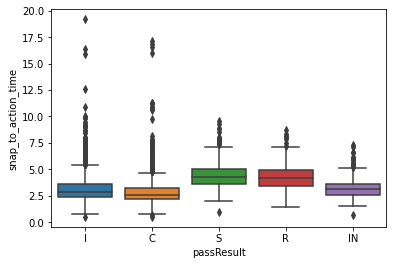

In [21]:
# Boxplot of the snap to action time vs pass result
box = sns.boxplot(data=ol_df, x="passResult", y="snap_to_action_time")
plt.show()

## **Defensive Line Analysis**

### **Individual**

In [22]:
# Get the player-level DL relevant data for players who played more than 30 snaps (to account for noise) 
# Note: potentially consider OLB in DL
high_snap_pass_rushers = player_level_df.query("officialPosition in ['NT','DT','DE'] and pff_role == 'Pass Rush'").nflId.value_counts().loc[lambda c: c > 35].index.tolist()
coi = ['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack']
dl_df = (player_level_df[coi].query(f"nflId in {high_snap_pass_rushers} and pff_role == 'Pass Rush'")
        .merge(snap_to_action_df, how='left', on=['gameId','playId'])
        .merge(rusher_dist_at_rel_df, how='left', on=['gameId','playId','nflId'])
        .merge(time_to_depth_df, how='left', on=['gameId','playId','nflId'])
        .merge(dl_num_blockers_df, how='left', on=['gameId','playId','nflId'])
        .merge(dl_pressure_df, how='left', on=['gameId','playId', 'nflId']))

dl_df.loc[dl_df.numBlockers.isna(), 'numBlockers'] = 0
dl_df.loc[dl_df.multBlockers.isna(), 'multBlockers'] = 'U'

# Clean up NAs
# A missing snap_to_action_time/distance at rel occurs when a certain play is missing either a snap or action event
dl_df = dl_df.dropna(subset=['snap_to_action_time','distance_at_rel'], how='any')

dl_df.head()

,gameId,playId,nflId,displayName,officialPosition,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,snap_to_action_time,distance_at_rel,time_to_depth,numBlockers,multBlockers,pressureOnPlay
0,2021090900,97,42403,Randy Gregory,DE,Pass Rush,ROLB,0.0,1.0,0.0,3.2,3.805391,1.1,1.0,N,1.0
1,2021090900,97,44955,Carlos Watkins,DE,Pass Rush,DRT,0.0,0.0,0.0,3.2,10.437672,1.8,2.0,Y,0.0
2,2021090900,97,53504,Osa Odighizuwa,DT,Pass Rush,RE,0.0,1.0,0.0,3.2,2.496498,2.0,0.0,U,1.0
3,2021090900,137,35441,Ndamukong Suh,DE,Pass Rush,DRT,0.0,0.0,0.0,2.6,3.635505,1.6,2.0,Y,0.0
4,2021090900,137,35454,Jason Pierre-Paul,DE,Pass Rush,ROLB,0.0,0.0,0.0,2.6,5.145600,1.9,1.0,N,0.0


In [23]:
# Check for NAs
# A missing time_to_depth occurs when the rusher did not make it to 3 yards or there is a missing snap time (potentially need to use another statistic)
if sum(dl_df.isna().sum().values) != 0:
    print(dl_df.isna().sum().loc[lambda x: x > 0])

time_to_depth    3615
dtype: int64


#### **Descriptive Statistics/Exploratory Plots**

In [24]:
# Contingency table (multiple blockers and pff pressure)
pd.crosstab(index=dl_df['multBlockers'], columns=dl_df['pressureOnPlay'], normalize=True)

pressureOnPlay,0.0,1.0
multBlockers,,
N,0.513536,0.071578
U,0.039364,0.009238
Y,0.342866,0.023417


<AxesSubplot: xlabel='pressureOnPlay', ylabel='time_to_depth'>

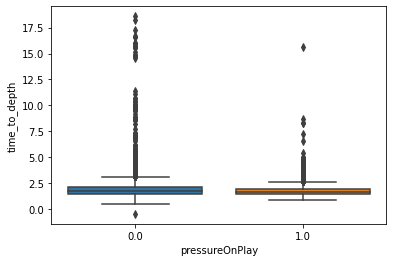

In [25]:
# Time to depth vs pff pressure
sns.boxplot(dl_df, x="pressureOnPlay", y="time_to_depth")

#### **Player-level averages**

In [26]:
# Get average EPA on passing plays by defensive team
# Note: for use with the avg epa per player. On average, how much better is the teams epa with vs without them on the field?
# team_avg_epa_df = play_level_df[['defensiveTeam','epa']].groupby(['defensiveTeam']).mean().rename(columns={"epa":"team_avg_epa"})

In [27]:
# Player-level average statistics
coi = ['nflId', 'displayName', 'officialPosition', 'snap_to_action_time',
    'distance_at_rel', 'pff_hit', 'pff_hurry', 'pff_sack', 'time_to_depth',
    'numBlockers', 'pressureOnPlay']

indy_dl_avg_df = dl_df[coi].groupby(['nflId', 'displayName', 'officialPosition']).mean().reset_index()

indy_dl_avg_df.sort_values(by=['pressureOnPlay'], ascending=[False]).head()

,nflId,displayName,officialPosition,snap_to_action_time,distance_at_rel,pff_hit,pff_hurry,pff_sack,time_to_depth,numBlockers,pressureOnPlay
89,44813,Myles Garrett,DE,3.095673,4.482110,0.043269,0.139423,0.057692,1.407000,1.110577,0.240385
156,47889,Maxx Crosby,DE,3.107798,4.370525,0.055046,0.137615,0.032110,1.458852,1.022936,0.224771
49,42403,Randy Gregory,DE,3.089041,4.489145,0.047945,0.130137,0.034247,1.636620,1.000000,0.212329
5,35470,Jerry Hughes,DE,3.203008,5.294614,0.022556,0.180451,0.007519,1.386555,0.969925,0.210526
103,44915,Trey Hendrickson,DE,3.179630,4.567773,0.027778,0.134259,0.046296,1.485096,1.064815,0.208333


#### **Player-level blocking stat frequencies**

In [28]:
# Frequencies of multBlockers on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'multBlockers']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['multBlockers','%'],ascending=[False,False])
.head(5))

,nflId,displayName,officialPosition,multBlockers,%
394,46618,Taylor Stallworth,DT,Y,0.675000
19,35522,Corey Peters,DT,Y,0.666667
63,39960,Star Lotulelei,DT,Y,0.660550
236,43638,Justin Zimmer,DT,Y,0.659574
302,44957,Grover Stewart,DT,Y,0.647059


In [29]:
# Frequencies of pressureOnPlay on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'pressureOnPlay']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['pressureOnPlay','%'],ascending=[False,False])
.head(5))

,nflId,displayName,officialPosition,pressureOnPlay,%
179,44813,Myles Garrett,DE,1.0,0.240385
313,47889,Maxx Crosby,DE,1.0,0.224771
99,42403,Randy Gregory,DE,1.0,0.212329
11,35470,Jerry Hughes,DE,1.0,0.210526
207,44915,Trey Hendrickson,DE,1.0,0.208333


In [30]:
# Frequencies of multBlockers/pressureOnPlay on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'multBlockers','pressureOnPlay']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['pressureOnPlay','%'],ascending=[False,False])
.head(5))


,nflId,displayName,officialPosition,multBlockers,pressureOnPlay,%
443,44813,Myles Garrett,DE,N,1.0,0.197115
27,35470,Jerry Hughes,DE,N,1.0,0.180451
518,44915,Trey Hendrickson,DE,N,1.0,0.166667
793,47889,Maxx Crosby,DE,N,1.0,0.155963
903,52462,A.J. Epenesa,DE,N,1.0,0.153846
